In [ ]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import re
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

from tqdm import tqdm

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

In [2]:
# Set device = CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

NameError: name 'torch' is not defined

In [3]:
# Reading CSV File into Pandas DataFrame

def read_data():
    # read data
    df = pd.read_csv('Data/hw1_train-1.csv', index_col=0)
    df.columns = ['text', 'labels']
    df['labels'] = df['labels'].str.replace('none', '')
    df['labels'] = df['labels'].fillna('')

    # Validating Set 
    train_df, val_df = train_test_split(
        df,
        random_state=0,
        test_size=0.2,
        shuffle=True)

    # Reading Test Dataset into DataFrame
    test_df = pd.read_csv('Data/hw1_test-2.csv', index_col=0)
    test_df.columns = ['text']

    return train_df, val_df, test_df


# get data
train_data, val_data, test_data = read_data()


print('Train Data count: ', len(train_data))
print('Validation Data count: ', len(val_data))
print('Test Data count: ', len(test_data))


Train Data count:  1849
Validation Data count:  463
Test Data count:  981


In [4]:
# Create a set of Labels and a Dictionary to keep count of all labels
label_set = set()
label_count_dict = {}

for index, row in train_data.iterrows():
    temp = row['labels'].split()
    for item in temp:
        label_set.add(item)
        label_count_dict[item] = label_count_dict.get(item, 0) + 1

label_list = np.reshape(np.array(list(label_set)), (-1, 1))

print('Label List: ', label_list[1:5])
print('Label Count Dictionary: ', label_count_dict)

Label List:  [['movie.production_companies']
 ['movie.rating']
 ['movie.gross_revenue']
 ['movie.country']]
Label Count Dictionary:  {'movie.produced_by': 145, 'movie.locations': 3, 'movie.country': 175, 'movie.language': 173, 'movie.genre': 106, 'movie.subjects': 76, 'movie.starring.actor': 282, 'movie.estimated_budget': 67, 'movie.initial_release_date': 152, 'movie.directed_by': 266, 'movie.rating': 172, 'movie.gross_revenue': 26, 'movie.production_companies': 80, 'movie.starring.character': 19, 'gr.amount': 4, 'actor.gender': 7, 'person.date_of_birth': 4, 'movie.music': 1}


In [5]:
# Fit Multi-Label Binarizer to Label List
mlb.fit(label_list)

# Enumerate classes for Labels        
id_to_label = {}
for idx, label in enumerate(mlb.classes_):
    id_to_label[idx] = label

print('Id to Label Dictionary: ')
_ = [print(idx, label) for idx, label in id_to_label.items()]

Id to Label Dictionary: 
0 actor.gender
1 gr.amount
2 movie.country
3 movie.directed_by
4 movie.estimated_budget
5 movie.genre
6 movie.gross_revenue
7 movie.initial_release_date
8 movie.language
9 movie.locations
10 movie.music
11 movie.produced_by
12 movie.production_companies
13 movie.rating
14 movie.starring.actor
15 movie.starring.character
16 movie.subjects
17 person.date_of_birth


In [6]:
# Fit Tf-Idf Vectorizer to training text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)

vectorizer.fit(train_data['text'])
print('Feature Names: ', vectorizer.get_feature_names_out())


def vectorize_to_tensor(text):
    text_list = []
    text_list.append(text)
    # Return tensor of encoded text using TF-IDF
    encoded = vectorizer.transform(text_list)
    encoded_tensor = torch.tensor(scipy.sparse.csr_matrix.todense(encoded)).float()
    return encoded_tensor

Feature Names:  ['1000' '1000 words' '13' ... 'zombie movies' 'zombies' 'zombies in']


In [7]:
# Relation Extraction Class for DataLoader
class RE_Dataset(Dataset):

    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.text = self.data['text']
        self.labels = self.data['labels']
        self.stopwords = English.Defaults.stop_words
        nlp = English()
        self.tokenizer = Tokenizer(nlp.vocab)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        text = self.text.iloc[idx]
        text = self.preprocess_text(self.text.iloc[idx])
        label = self.labels.iloc[idx].split()
        return self.encode_text(text), self.encode_label(label)

    def encode_text(self, text: str):
        return vectorize_to_tensor(text)

    def encode_label(self, label: str):
        # Convert label into NumPy matrix
        label_array = np.array(label)
        label_matrix = np.reshape(label_array,
                                  (1, -1))
        # Return tensor of encoded label using Multi-Label Binarizer
        encoded = mlb.transform(label_matrix)
        encoded_label = torch.from_numpy(encoded)
        return encoded_label

    def tokenize(self, text: str):
        return [i.text for i in self.tokenizer(text)]

    def stopword_removal(self, text: str):
        corpus = []
        for item in self.tokenize(text):
            if item not in self.stopwords:
                corpus.append(item)
        corpus = ' '.join(corpus)
        return corpus

    def preprocess_text(self, text: str):
        # Convert text to lowercase
        text = text.lower()
        # Removing text contractions
        text = re.sub(r"there's", "there is", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"who's", "who is", text)
        text = re.sub(r"you're", "you are", text)
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"i'd", "i would", text)
        text = re.sub(r"ain't", "am not", text)
        text = re.sub(r"don't", "donot", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"could't", "could not", text)
        text = re.sub(r"should'nt", "should not", text)
        text = re.sub(r"won't", "will not", text)
        # Removing all punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Removing links
        text = re.sub(r'http\S+', '', text)
        # Removing special characters and numbers
        text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
        # Removing single characters
        text = re.sub(r's+[a-zA-Z]s+', '', text)
        # Removing stopwords
        text = self.stopword_removal(text)
        # Replacing multi-spaces by a single space
        text = re.sub(r'\s+', ' ', text)
        return text

In [8]:
# Relation Extraction Object for DataLoader
train_ds = RE_Dataset(train_data)
val_ds = RE_Dataset(val_data)

In [9]:
# PyTorch Data Loader
train_loader = DataLoader(
    train_ds, batch_size=16, shuffle=True
)

val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=True
)


torch.manual_seed(32)
input_features_dim = train_ds[0][0].shape[1]
output_dim = len(label_set)

print('Input(Features) Dimensions: {} \nOutput Dimensions: {}'.format(
    input_features_dim, output_dim))


Input(Features) Dimensions: 1642 
Output Dimensions: 18


#### Models

Here we have couple of models that we've tried in the process of getting the best result.

In [10]:
# Multi-Layer Perceptron with 1 hidden layer
class MLP(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim, 
        output_dim
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, 
                x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output  


# Multi-Layer Perceptron with 2 hidden layers
class MLP_2(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim_1,
        hidden_dim_2,
        output_dim
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, 
                x):
        hidden1 = self.fc1(x)
        relu1 = self.relu(hidden1)
        hidden2 = self.fc2(relu1)
        relu2 = self.relu(hidden2)
        hidden3 = self.fc3(relu2)
        output = self.sigmoid(hidden3)
        return output  


# MLP model with 1 hidden layers and regularization using Dropout
class MLP_Dropout_Leaky(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim,
        output_dim
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, 
                x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        dropout = self.dropout(relu)
        output = self.fc2(dropout)
        output = self.sigmoid(output)
        return output
    


# MLP model with 3 hidden layers
class MLP_3(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim_1,
        hidden_dim_2,
        hidden_dim_3,
        output_dim
    ):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, output_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, 
                x):
        hidden1 = self.fc1(x)
        relu1 = self.relu(hidden1)
        hidden2 = self.fc2(relu1)
        relu2 = self.relu(hidden2)
        hidden3 = self.fc3(relu2)
        relu3 = self.relu(hidden3)
        hidden4 = self.fc4(relu3)
        output = self.sigmoid(hidden4)
        return output

# Bi-LSTM with 1 hidden layer
class BiLSTM(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim,
        output_dim
    ):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, 
                x):
        lstm_out, _ = self.lstm(x)
        hidden1 = self.fc1(lstm_out)
        output = self.sigmoid(hidden1)
        return output


# Bi-LSTM with 3 hidden layer
class BiLSTM_3(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim_1,
        hidden_dim_2,
        hidden_dim_3,
        output_dim
    ):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim_1, bidirectional=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_dim_1 * 2, hidden_dim_2)
        self.fc2 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc3 = nn.Linear(hidden_dim_3, output_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, 
                x):
        lstm_out, _ = self.lstm(x)
        relu1 = self.relu(lstm_out)
        hidden1 = self.fc1(relu1)
        relu2 = self.relu(hidden1)
        hidden2 = self.fc2(relu2)
        relu3 = self.relu(hidden2)
        hidden3 = self.fc3(relu3)
        output = self.sigmoid(hidden3)
        return output



#### Model Selection

In [11]:


def get_model(choosen_model) -> nn.Module:

    if choosen_model == 'mlp_2':
        return MLP_2(
            input_dim=input_features_dim, 
            hidden_dim_1=50,
            hidden_dim_2=50,
            output_dim=output_dim
            ).to(device)
    
    elif choosen_model == 'mlp_1':
        return MLP(
            input_dim=input_features_dim, 
            hidden_dim=50,
            output_dim=output_dim
            ).to(device)


    elif choosen_model == 'mlp_3':
        return MLP_3(
            input_dim=input_features_dim, 
            hidden_dim_1=50,
            hidden_dim_2=50,
            hidden_dim_3=50,
            output_dim=output_dim
            ).to(device)

    elif choosen_model == 'mlp_dropout_leaky':
        return MLP_Dropout_Leaky(
            input_dim=input_features_dim, 
            hidden_dim=50,
            output_dim=output_dim
            ).to(device)
    

    elif choosen_model == 'bilstm':
        return BiLSTM(
            input_dim=input_features_dim,
            hidden_dim=50,
            output_dim=output_dim
            ).to(device)

    elif choosen_model == 'bilstm_3':
        return BiLSTM_3(
            input_dim=input_features_dim, 
            hidden_dim_1=50,
            hidden_dim_2=50,
            hidden_dim_3=50,
            output_dim=output_dim
            ).to(device)



# Options: mlp_1, mlp_2, mlp_3, mlp_dropout_leaky, bilstm, bilstm_3
choosen_model = 'mlp_1'
model = get_model(choosen_model)

print(model)

MLP(
  (fc1): Linear(in_features=1642, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=18, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:
# Model Train Function
def train(loader, model, optimizer, loss_function):

    model.train()
    losses = []
    for batch in tqdm(loader):
        x, y = batch

        optimizer.zero_grad()
        
        y_pred = model(x)
        y = y.squeeze().to(torch.float32)
        y_pred = y_pred.squeeze().to(torch.float32)
        
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return sum(losses) / len(losses)


# Model Evaluate Function
def evaluate(loader, model, loss_function, score_function):

    model.eval()
    predictions, labels, losses = [], [], []
    
    for batch in tqdm(loader):
        x, y = batch

        y_pred = model(x)
        y_pred = torch.round(y_pred)

        y = y.squeeze().to(torch.float32)
        y_pred = y_pred.squeeze().to(torch.float32)

        
        loss = loss_function(y_pred, y)
        losses.append(loss.item())

        y = y.detach().numpy()
        y_pred = y_pred.detach().numpy()

        labels.append(y)
        predictions.append(y_pred)

    score = score_function(labels, predictions, average='samples', zero_division=1)
    return labels, predictions, sum(losses) / len(losses), score

In [13]:
# Model Training on Train dataset and Evaluation on Validation dataset

def evaluate_model(model, train_loader, val_loader, optimizer, loss, score, model_name, epochs=10):
    best_acc = 0
    train_losses, val_losses, val_scores = [], [], []
    for epoch in range(epochs):
        print(f'---------- \nEpoch {epoch + 1}/{epochs}')

        train_loss = train(train_loader, model, optimizer, loss)
        print(f'Train loss {train_loss}')
        train_losses.append(train_loss)

        labels, predictions, val_loss, val_score = evaluate(val_loader, model, loss, score)
        print('Score: {:0.4f} \t Validation loss {:0.4f}'.format(val_score, val_loss))
        val_losses.append(val_loss)
        val_scores.append(val_score)

        # Save model if Validation F1_Score is greather than 75%
        if val_score > 0.75 and val_score > best_acc:
        
            torch.save(model.state_dict(), model_name)
            cm = multilabel_confusion_matrix(labels, predictions)

    return train_losses, val_losses, val_scores



optimizer = torch.optim.Adam(model.parameters(), lr=0.04)
loss_func = nn.BCELoss()
score_func = f1_score

n_epochs = 10
model_name = 'best_model.pt'

train_loss_list, val_loss_list, f1_score_list = evaluate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss=loss_func,
    score=score_func,
    model_name=model_name,
    epochs=n_epochs
    )

print('Best F1 Score: {:0.4f}'.format(max(f1_score_list)))

---------- 
Epoch 1/10


100%|██████████| 116/116 [00:02<00:00, 53.12it/s]


Train loss 0.16047381850537554


100%|██████████| 463/463 [00:00<00:00, 705.85it/s]


Score: 0.7140 	 Validation loss 2.1718
---------- 
Epoch 2/10


100%|██████████| 116/116 [00:02<00:00, 39.59it/s]


Train loss 0.04028658630278219


100%|██████████| 463/463 [00:00<00:00, 590.70it/s]


Score: 0.7526 	 Validation loss 2.0758
---------- 
Epoch 3/10


100%|██████████| 116/116 [00:02<00:00, 42.64it/s]


Train loss 0.02525667998747065


100%|██████████| 463/463 [00:00<00:00, 535.34it/s]


Score: 0.7633 	 Validation loss 2.0038
---------- 
Epoch 4/10


100%|██████████| 116/116 [00:02<00:00, 52.64it/s]


Train loss 0.02114677535980169


100%|██████████| 463/463 [00:00<00:00, 613.95it/s]


Score: 0.7708 	 Validation loss 2.1598
---------- 
Epoch 5/10


100%|██████████| 116/116 [00:03<00:00, 34.96it/s]


Train loss 0.01698592515032064


100%|██████████| 463/463 [00:01<00:00, 360.89it/s]


Score: 0.7442 	 Validation loss 2.1958
---------- 
Epoch 6/10


100%|██████████| 116/116 [00:03<00:00, 29.88it/s]


Train loss 0.01604229362946453


100%|██████████| 463/463 [00:01<00:00, 435.25it/s]


Score: 0.7510 	 Validation loss 1.9918
---------- 
Epoch 7/10


100%|██████████| 116/116 [00:02<00:00, 48.19it/s]


Train loss 0.01536664993006431


100%|██████████| 463/463 [00:00<00:00, 561.76it/s]


Score: 0.7629 	 Validation loss 2.1238
---------- 
Epoch 8/10


100%|██████████| 116/116 [00:02<00:00, 46.22it/s]


Train loss 0.014144454873217157


100%|██████████| 463/463 [00:00<00:00, 640.31it/s]


Score: 0.7521 	 Validation loss 2.1358
---------- 
Epoch 9/10


100%|██████████| 116/116 [00:02<00:00, 45.92it/s]


Train loss 0.01267899190961857


100%|██████████| 463/463 [00:00<00:00, 561.53it/s]


Score: 0.7467 	 Validation loss 2.2198
---------- 
Epoch 10/10


100%|██████████| 116/116 [00:02<00:00, 48.48it/s]


Train loss 0.01353183819515709


100%|██████████| 463/463 [00:00<00:00, 659.63it/s]

Score: 0.7568 	 Validation loss 2.1598
Best F1 Score: 0.7708


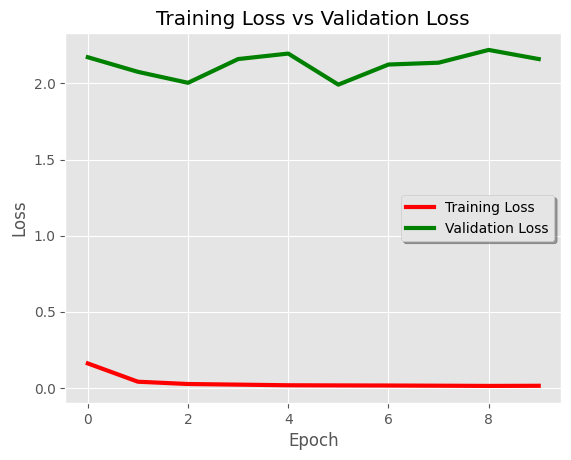

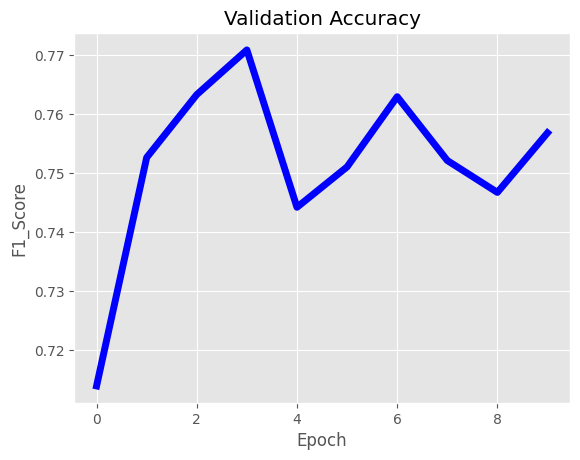

In [14]:
# Training vs Validation Loss Plot
epochs = np.arange(0, n_epochs)
# print('Train Loss: ', train_loss_list)
# print('Val Loss: ', val_loss_list)

plt.style.use('ggplot')
plt.plot(epochs, train_loss_list, label="Training Loss", color="red", linewidth='3')
plt.plot(epochs, val_loss_list, label="Validation Loss", color="green", linewidth='3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss', color='black')
plt.legend(shadow=True, labelcolor='black')
plt.show()

# Validation Accuracy Plot
plt.plot(epochs, f1_score_list, color='blue', linewidth='5')
plt.xlabel('Epoch')
plt.ylabel('F1_Score')
plt.title('Validation Accuracy', color='black')
plt.show()

Load Model

In [15]:
# load model 

saved_model = get_model(choosen_model)

saved_model.load_state_dict(torch.load(model_name))
saved_model.eval()

MLP(
  (fc1): Linear(in_features=1642, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=18, bias=True)
  (sigmoid): Sigmoid()
)

Predict relations

In [16]:

# Use loaded Model for Predictions
label_tensors = []
label_id = []
with torch.no_grad():
    for index, row in test_data.iterrows():
        text_tensor = vectorize_to_tensor(row.to_string())
        
        # Using Forward Pass of MLP for Predictions
        label_tensor = model.forward(text_tensor)
        label_tensor_round = torch.round(label_tensor)
        label_tensors.append(label_tensor_round)
        
        # Use Inverse_Transform function in MultiLabelBinarizer to get label names
        label_id.append(mlb.inverse_transform(label_tensor_round))


relations = []
for i in range(0, len(label_id)):
    pred_labels = list(label_id[i][0])
    d = {
        "ID": i,
        "UTTERANCEs": ' '.join(pred_labels)
    }
    relations.append(d)


labels_df = pd.DataFrame.from_dict(relations)
labels_df.to_csv('submission_labels.csv', index=False)

print(labels_df)

      ID                                     UTTERANCEs
0      0                           movie.starring.actor
1      1                                               
2      2                           movie.starring.actor
3      3                                               
4      4                                               
..   ...                                            ...
976  976  movie.starring.actor movie.starring.character
977  977                           movie.starring.actor
978  978                                               
979  979                              movie.directed_by
980  980                                  movie.country

[981 rows x 2 columns]
